In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os


In [ ]:
def create_folder_if_not_exists(folder_path):
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
        print(f"Folder {folder_path} created successfully.")
    else:
        print(f"Folder {folder_path} already exists.")


create_folder_if_not_exists("plots")
create_folder_if_not_exists("errors")

**Równomierna dystrybucja**

In [ ]:
def even_domain(x_min, x_max, number_of_points):
    return np.linspace(x_min, x_max, number_of_points, dtype=np.double)

**Zera wielomianu Czebyszewa**

In [ ]:
def get_chebyshev_zeros(x_min=None, x_max=None, number_of_points=None):
    if x_min is None and x_max is not None or x_min is not None and x_max is None:
        raise ValueError("x_min and x_max must be both None or both not None")
    chebyshev_zeroes = np.array(0, dtype=np.double)
    for k in range(number_of_points):
        cur_zero = np.cos((2 * k + 1) * np.pi / (2 * number_of_points))
        if x_min is not None and x_max is not None:
            cur_zero = (x_max - x_min) / 2 * cur_zero + (x_max + x_min) / 2
        chebyshev_zeroes = np.append(chebyshev_zeroes, cur_zero)
    return chebyshev_zeroes[1:]

**Interpolacja Lagrange'a**

In [ ]:
def lagrange_interpolation(function, x, x_zeroes):
    def Lk(k, x):
        nonlocal n
        d = 1
        for i in range(n):
            if i != k:
                d *= (x - x_zeroes[i])
        m = 1
        for i in range(n):
            if i != k:
                m *= (x_zeroes[k] - x_zeroes[i])
        return d / m

    Pn = 0
    n = len(x_zeroes)
    for k in range(n):
        Pn += Lk(k, x) * function(x_zeroes[k])
    return Pn


def interpolate_lagrange(function, domain, x_zeroes):
    result = []
    for i in range(len(domain)):
        result.append(lagrange_interpolation(function=function, x=domain[i], x_zeroes=x_zeroes))
    return result

**Interpolacja Newtona**

In [ ]:
def newton_interpolation(function, x, x_zeroes):
    n = len(x_zeroes)

    def get_difference_quotient_table():
        nonlocal function
        nonlocal x_zeroes
        nonlocal n
        table = np.zeros((n, n), dtype=np.double)
        for i in range(n):
            table[i][0] = function(x_zeroes[i])
        for j in range(1, n):
            for i in range(n - j):
                table[i][j] = (table[i + 1][j - 1] - table[i][j - 1]) / (x_zeroes[i + j] - x_zeroes[i])
        return table

    difference_quotient_table = get_difference_quotient_table()
    Pn = 0
    for k in range(0, n):
        cur_number = difference_quotient_table[0][k]
        for i in range(0, k):
            cur_number *= (x - x_zeroes[i])
        Pn += cur_number
    return Pn


def interpolate_newton(function, domain, x_zeroes):
    result = []
    for i in range(len(domain)):
        result.append(newton_interpolation(function=function, x=domain[i], x_zeroes=x_zeroes))
    return result

**Wizualizacja**

In [ ]:
def visualise(domain=None, nodes_x=None, nodes_y=None, f_y=None, Pn_x=None, mode=None, x_size=8, y_size=6,
              filename=None):
    '''
    :param domain: array of float64, of x coordinates of points to visualise
    :param nodes_x: array of x coordinates of nodes
    :param nodes_y: array of f(x) for each x in nodes_x
    :param f_y: array of f(x) for each x in domain
    :param Pn_x: array of Pn(x) for each x in domain
    :param mode: "lagrange" or "newton" or "impo"
    :param x_size: size of a figure in x axis
    :param y_size: size of a figure in y axis
    :param filename: name of a file to save a figure
    :return: None
    '''
    plt.figure(figsize=(x_size, y_size))
    if nodes_x is not None and nodes_y is not None:
        plt.scatter(nodes_x, nodes_y, label="Węzły", color="green")
    if f_y is not None:
        plt.plot(domain, f_y, label="Zadana funckcja", color="blue")

    if mode == "lagrange":
        plt.plot(domain, Pn_x, label="Interpolacja Lagrange'a", color="red")
    elif mode == "newton":
        plt.plot(domain, Pn_x, label="Interpolacja Newtona", color="red")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    if filename is not None:
        plt.savefig(f"plots/{filename}.png", dpi=300, format='png')
    plt.show()


**Implementacja funkcji do laboratorium**

In [ ]:
pi = np.double(np.pi)
interval_start = -2 * pi
interval_end = pi
base_domain = np.arange(interval_start, interval_end, 0.01)


def function_given(x):
    m = 2
    k = 2
    global pi
    return np.sin(m * x) * np.sin(k * (x * x) / pi)


function_given_values = []
for random_name in range(len(base_domain)):
    function_given_values.append(function_given(base_domain[random_name]))


def get_function_values(X):
    result = np.zeros(len(X), dtype=np.double)
    for i in range(len(X)):
        result[i] = function_given(X[i])
    return result


def get_abs_error(f1, f2):
    max_error = -1
    if len(f1) != len(f2):
        raise Exception("f1 and f2 must have the same length")
    for i in range(len(f1)):
        max_error = max(max_error, abs(f1[i] - f2[i]))
    return max_error


def get_square_mean_error(f1, f2):
    error_sum = 0
    if len(f1) != len(f2):
        raise Exception("f1 and f2 must have the same length")
    for i in range(len(f1)):
        error_sum += (f1[i] - f2[i]) ** 2
    return np.sqrt(error_sum) / len(f1)


def visualise_lagrange(number_of_nodes, domain, function, nodes_distribution_mode="even", filename=None):
    nodes_x = None
    if nodes_distribution_mode == "even":
        nodes_x = even_domain(x_min=interval_start, x_max=interval_end, number_of_points=number_of_nodes)
    elif nodes_distribution_mode == "chebyshev":
        nodes_x = get_chebyshev_zeros(x_min=interval_start, x_max=interval_end, number_of_points=number_of_nodes)
    nodes_y = []
    for i in range(len(nodes_x)):
        nodes_y.append(function(nodes_x[i]))
    lagrange_values = interpolate_lagrange(function=function, domain=domain, x_zeroes=nodes_x)
    visualise(domain=base_domain, nodes_x=nodes_x, nodes_y=nodes_y, f_y=function_given_values, Pn_x=lagrange_values,
              mode="lagrange", filename=filename)


def visualise_newton(number_of_nodes, domain, function, nodes_distribution_mode="even", filename=None):
    nodes_x = None
    if nodes_distribution_mode == "even":
        nodes_x = even_domain(x_min=interval_start, x_max=interval_end, number_of_points=number_of_nodes)
    elif nodes_distribution_mode == "chebyshev":
        nodes_x = get_chebyshev_zeros(x_min=interval_start, x_max=interval_end, number_of_points=number_of_nodes)
    nodes_y = []
    for i in range(len(nodes_x)):
        nodes_y.append(function(nodes_x[i]))
    newton_values = interpolate_newton(function=function, domain=domain, x_zeroes=nodes_x)
    visualise(domain=base_domain, nodes_x=nodes_x, nodes_y=nodes_y, f_y=function_given_values, Pn_x=newton_values,
              mode="newton", filename=filename)

**Wykonanie ćwiczenia**

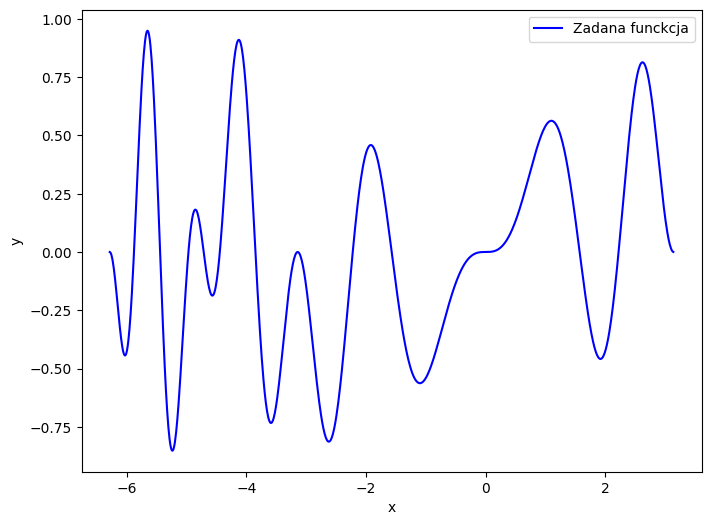

In [11]:
visualise(base_domain, None, None, function_given_values)
#given_number_of_nodes = [3, 4, 5, 7, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70]
given_number_of_nodes = range(3, 71)

In [ ]:
def get_all_visualisations(number):
    print("Liczba węzłów: ", number)
    even_nodes = even_domain(x_min=interval_start, x_max=interval_end, number_of_points=number)
    chebyshev_nodes = get_chebyshev_zeros(x_min=interval_start, x_max=interval_end, number_of_points=number)
    print("Wizualizacja Lagrange, węzły równoodległe")
    visualise_lagrange(number_of_nodes=number,
                       domain=base_domain,
                       function=function_given,
                       nodes_distribution_mode="even",
                       filename=f"lagrange_{number}_even")
    print("Wizualizacja Lagrange, węzły Czebyszewa")
    visualise_lagrange(number_of_nodes=number,
                       domain=base_domain,
                       function=function_given,
                       nodes_distribution_mode="chebyshev",
                       filename=f"lagrange_{number}_chebyshev")
    print("Wizualizacja Newtona, węzły równoodległe")
    visualise_newton(number_of_nodes=number,
                     domain=base_domain,
                     function=function_given,
                     nodes_distribution_mode="even",
                     filename=f"newton_{number}_even")
    print("Wizualizacja Newtona, węzły Czebyszewa")
    visualise_newton(number_of_nodes=number,
                     domain=base_domain,
                     function=function_given,
                     nodes_distribution_mode="chebyshev",
                     filename=f"newton_{number}_chebyshev")


for cur_number in given_number_of_nodes:
    get_all_visualisations(cur_number)

In [12]:
import csv


def save_to_csv(filename, data):
    with open(filename, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerows(data)

In [17]:

def lagrange_results_errors():
    global given_number_of_nodes
    even_abs_nodes = 0
    even_abs = 1000

    even_square_nodes = 0
    even_square = 1000

    chebysev_abs_nodes = 0
    chebysev_abs = 1000

    chebysev_square_nodes = 0
    chebysev_square = 1000
    csv_header = ["Liczba węzłów", "Równoodległe, błąd maksymalny, ", "Równoodległe, błąd kwadratowy",
                  "Czebyszew, błąd maksymalny", "Czebyszew, błąd kwadratowy"]
    csv_file = [csv_header]
    for number_of_nodes in given_number_of_nodes:
        csv_record = [number_of_nodes]
        even_nodes = even_domain(x_min=interval_start, x_max=interval_end, number_of_points=number_of_nodes)
        chebyshev_nodes = get_chebyshev_zeros(x_min=interval_start, x_max=interval_end,
                                              number_of_points=number_of_nodes)
        exact_result = []
        for i in range(len(base_domain)):
            exact_result.append(function_given(base_domain[i]))
        lagrange_even_result = interpolate_lagrange(function=function_given, domain=base_domain, x_zeroes=even_nodes)
        lagrange_even_abs_error = get_abs_error(exact_result, lagrange_even_result)
        if lagrange_even_abs_error < even_abs:
            even_abs_nodes = number_of_nodes
            even_abs = lagrange_even_abs_error
        csv_record.append(lagrange_even_abs_error)
        lagrange_even_sqrt_error = get_square_mean_error(exact_result, lagrange_even_result)
        if lagrange_even_sqrt_error < even_square:
            even_square_nodes = number_of_nodes
            even_square = lagrange_even_sqrt_error
        csv_record.append(lagrange_even_sqrt_error)

        lagrange_chebyshev_result = interpolate_lagrange(function=function_given, domain=base_domain,
                                                         x_zeroes=chebyshev_nodes)
        lagrange_chebyshev_abs_error = get_abs_error(exact_result, lagrange_chebyshev_result)
        if lagrange_chebyshev_abs_error < chebysev_abs:
            chebysev_abs_nodes = number_of_nodes
            chebysev_abs = lagrange_chebyshev_abs_error
        csv_record.append(lagrange_chebyshev_abs_error)
        lagrange_chebyshev_sqrt_error = get_square_mean_error(exact_result, lagrange_chebyshev_result)
        if lagrange_chebyshev_sqrt_error < chebysev_square:
            chebysev_square_nodes = number_of_nodes
            chebysev_square = lagrange_chebyshev_sqrt_error
        csv_record.append(lagrange_chebyshev_sqrt_error)
        csv_file.append(csv_record)

    print(f"Minimalny błąd bezwzględny dla węzłów równoodległych: {even_abs} dla {even_abs_nodes} węzłów")
    print(f"Minimalny błąd kwadratowy dla węzłów równoodległych: {even_square} dla {even_square_nodes} węzłów")
    print(f"Minimalny błąd bezwzględny dla węzłów Czebyszewa: {chebysev_abs} dla {chebysev_abs_nodes} węzłów")
    print(f"Minimalny błąd kwadratowy dla węzłów Czebyszewa: {chebysev_square} dla {chebysev_square_nodes} węzłów")
    save_to_csv("errors/lagrange_errors.csv", csv_file)


lagrange_results_errors()


Minimalny błąd bezwzględny dla węzłów równoodległych: 0.4354391261641133 dla 61 węzłów
Minimalny błąd kwadratowy dla węzłów równoodległych: 0.0007898235824220215 dla 61 węzłów
Minimalny błąd bezwzględny dla węzłów Czebyszewa: 4.3391156688771595e-14 dla 70 węzłów
Minimalny błąd kwadratowy dla węzłów Czebyszewa: 4.228478046844019e-16 dla 70 węzłów


In [21]:
def newton_results_errors():
    global given_number_of_nodes
    even_abs_nodes = 0
    even_abs = 1000

    even_square_nodes = 0
    even_square = 1000

    chebysev_abs_nodes = 0
    chebysev_abs = 1000

    chebysev_square_nodes = 0
    chebysev_square = 1000
    csv_header = ["Liczba węzłów", "Równoodległe, błąd maksymalny, ", "Równoodległe, błąd kwadratowy",
                  "Czebyszew, błąd maksymalny", "Czebyszew, błąd kwadratowy"]
    csv_file = [csv_header]
    for number_of_nodes in given_number_of_nodes:
        csv_record = [number_of_nodes]
        even_nodes = even_domain(x_min=interval_start, x_max=interval_end, number_of_points=number_of_nodes)
        chebyshev_nodes = get_chebyshev_zeros(x_min=interval_start, x_max=interval_end,
                                              number_of_points=number_of_nodes)
        exact_result = []
        for i in range(len(base_domain)):
            exact_result.append(function_given(base_domain[i]))

        newton_even_result = interpolate_newton(function=function_given, domain=base_domain, x_zeroes=even_nodes)
        newton_even_abs_error = get_abs_error(exact_result, newton_even_result)
        if newton_even_abs_error < even_abs:
            even_abs_nodes = number_of_nodes
            even_abs = newton_even_abs_error
        csv_record.append(newton_even_abs_error)
        newton_even_sqrt_error = get_square_mean_error(exact_result, newton_even_result)
        if newton_even_sqrt_error < even_square:
            even_square_nodes = number_of_nodes
            even_square = newton_even_sqrt_error
        csv_record.append(newton_even_sqrt_error)

        newton_chebyshev_result = interpolate_newton(function=function_given, domain=base_domain,
                                                     x_zeroes=chebyshev_nodes)
        newton_chebyshev_abs_error = get_abs_error(exact_result, newton_chebyshev_result)
        if newton_chebyshev_abs_error < chebysev_abs:
            chebysev_abs_nodes = number_of_nodes
            chebysev_abs = newton_chebyshev_abs_error
        csv_record.append(newton_chebyshev_abs_error)
        newton_chebyshev_sqrt_error = get_square_mean_error(exact_result, newton_chebyshev_result)
        if newton_chebyshev_sqrt_error < chebysev_square:
            chebysev_square_nodes = number_of_nodes
            chebysev_square = newton_chebyshev_sqrt_error
        csv_record.append(newton_chebyshev_sqrt_error)
        csv_file.append(csv_record)
    print(f"Minimalny błąd bezwzględny dla węzłów równoodległych: {even_abs} dla {even_abs_nodes} węzłów")
    print(f"Minimalny błąd kwadratowy dla węzłów równoodległych: {even_square} dla {even_square_nodes} węzłów")
    print(f"Minimalny błąd bezwzględny dla węzłów Czebyszewa: {chebysev_abs} dla {chebysev_abs_nodes} węzłów")
    print(f"Minimalny błąd kwadratowy dla węzłów Czebyszewa: {chebysev_square} dla {chebysev_square_nodes} węzłów")
    save_to_csv("errors/newton_errors.csv", csv_file)


newton_results_errors()

Minimalny błąd bezwzględny dla węzłów równoodległych: 0.9494183612268197 dla 3 węzłów
Minimalny błąd kwadratowy dla węzłów równoodległych: 0.014218622609596013 dla 7 węzłów
Minimalny błąd bezwzględny dla węzłów Czebyszewa: 0.0018865283732164802 dla 39 węzłów
Minimalny błąd kwadratowy dla węzłów Czebyszewa: 1.201045967458498e-05 dla 42 węzłów
